# Closing Credit Recognizer Feasability

Within this notebook I explore the feasability of the idea to see if using convolutional we can classify frames into classes of Movie Screenshot and Closing Credit.

At this stage you should have the dataset in place in separate directories, we first create directories for training and validation data and break the dataset into training and validation before training the models.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models, optimizers
from pathlib import Path
import os, shutil

data_path = Path('../data/')
directories = ['closing_credits', 'movie_screenshot']

data_path = Path('../data/')
dataset_path = data_path/'dataset'
train = dataset_path/'train'
valid = dataset_path/'valid'

for directory in directories:
    train_path = train/directory
    train_path.mkdir(parents=True, exist_ok=True)
    valid_path = valid/directory
    valid_path.mkdir(parents=True, exist_ok=True)

### Run this block of code only once to randomly break the images into training and validation and move them to the corresponding directory

In [3]:
# for directory in directories:
#     fnames = sorted(os.listdir(dataset_path/directory))
#     fnames = [fname for fname in fnames if fname[-4] == '.' or fname[-5] == '.']
#     indices = np.arange(len(fnames), dtype=np.int16)
#     np.random.shuffle(fnames)
#     train_path = train/directory
#     valid_path = valid/directory
#     break_point = int(len(fnames) * 0.2)
#     for fname in fnames[:break_point]:
#         shutil.copyfile(dataset_path/directory/fname, valid_path/fname)
#     for fname in fnames[break_point:]:
#         shutil.copyfile(dataset_path/directory/fname, train_path/fname)

### Assessing the idea using an arbitrary CNN

For the first attempt I created a simple arbitrary Convolutional Neural Network to see if it can differentiate between classes.

In [8]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

### Creating the data generators

In order to feed the data to our network we have to create Keras Data Generators. No data augmentation at this point is done. We only normalise the values to be between 0 and 1. There are 400 training examples and 100 for validation.

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train,
        target_size=(224, 224),
        batch_size=40,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        valid,
        target_size=(224, 224),
        batch_size=25,
        class_mode='binary')

Found 401 images belonging to 2 classes.
Found 99 images belonging to 2 classes.


### Training the first model

Finally, model is being trained in the following code block and we save it on the disk.

In [5]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=10,
      epochs=35,
      validation_data=validation_generator,
      validation_steps=4)

model.save('model/closing_credits_simple_CNN.h5')

Instructions for updating:
Use tf.cast instead.
Epoch 1/35
10/10 [==============================] - 35s 4s/step - loss: 0.6833 - acc: 0.6175 - val_loss: 0.6176 - val_acc: 0.7800
Epoch 2/35
10/10 [==============================] - 6s 595ms/step - loss: 0.5354 - acc: 0.7350 - val_loss: 0.5893 - val_acc: 0.7800
Epoch 3/35
10/10 [==============================] - 9s 929ms/step - loss: 0.5051 - acc: 0.7500 - val_loss: 0.5336 - val_acc: 0.8200
Epoch 4/35
10/10 [==============================] - 9s 883ms/step - loss: 0.4321 - acc: 0.8125 - val_loss: 0.5195 - val_acc: 0.7900
Epoch 5/35
10/10 [==============================] - 9s 909ms/step - loss: 0.3894 - acc: 0.8575 - val_loss: 0.4561 - val_acc: 0.8400
Epoch 6/35
10/10 [==============================] - 9s 887ms/step - loss: 0.3878 - acc: 0.8375 - val_loss: 0.4734 - val_acc: 0.8000
Epoch 7/35
10/10 [==============================] - 9s 910ms/step - loss: 0.4103 - acc: 0.8400 - val_loss: 0.4412 - val_acc: 0.8400
Epoch 8/35
10/10 [============

### Plotting training and validation's accuracy and loss

It can be observed that model is doing very well already! Achieving an accuracy above 0.90 and no sign of overfitting. Given this result it can be said that we can use such a model for our purposes, and so it is feasable.

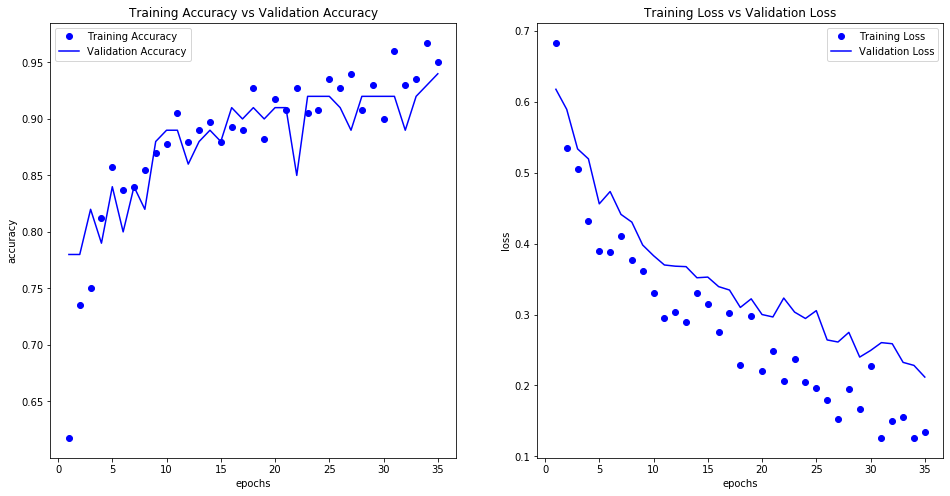

In [6]:
def plot_train_vs_valid(history):
    acc = history.history['acc']
    loss = history.history['loss']
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc)+1)
    fig = plt.figure()
    fig.set_figheight(8)
    fig.set_figwidth(16)
    ax = fig.add_subplot(1,2,1)
    ax.plot(epochs, acc, 'bo', label='Training Accuracy')
    ax.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    ax.set_title('Training Accuracy vs Validation Accuracy')
    ax.set_xlabel('epochs')
    ax.set_ylabel('accuracy')
    ax.legend()
    ax = fig.add_subplot(1,2,2)
    ax.plot(epochs, loss, 'bo', label='Training Loss')
    ax.plot(epochs, val_loss, 'b', label='Validation Loss')
    ax.set_title('Training Loss vs Validation Loss')
    ax.set_xlabel('epochs')
    ax.set_ylabel('loss')
    ax.legend()
    plt.show()
    
plot_train_vs_valid(history)

### Transfer Learning Using ResNet50

Now that we have reached the conclusion that it's possible to differentiate between rolling credits and snapshots of movies let's try out a pretrained ResNet50 model to check what would happen.

In [7]:
from keras.applications import ResNet50

In [8]:
conv_base = ResNet50(weights='imagenet',
                     include_top=False,
                     input_shape=(224, 224, 3))

conv_base.summary()

/home/jupyter/.local/share/virtualenvs/closing-credits-recognizer-L-5h7F88/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [9]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

### Freezing the layers except the last ones

Here I have freezed all the layers except the last 35 layers to disable weights getting updated during training.

In [13]:
conv_base.trainable = True

for layer in conv_base.layers:
    layer.trainable = False
for layer in conv_base.layers[-35:]:
    layer.trainable = True

In [11]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=10,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=4)

Epoch 1/10
10/10 [==============================] - 14s 1s/step - loss: 1.1400 - acc: 0.7875 - val_loss: 0.0134 - val_acc: 1.0000
Epoch 2/10
10/10 [==============================] - 6s 628ms/step - loss: 0.0367 - acc: 0.9900 - val_loss: 0.0091 - val_acc: 1.0000
Epoch 3/10
10/10 [==============================] - 9s 890ms/step - loss: 0.0039 - acc: 1.0000 - val_loss: 0.0088 - val_acc: 1.0000
Epoch 4/10
10/10 [==============================] - 9s 937ms/step - loss: 7.1445e-04 - acc: 1.0000 - val_loss: 0.0090 - val_acc: 1.0000
Epoch 5/10
10/10 [==============================] - 10s 987ms/step - loss: 0.0050 - acc: 0.9975 - val_loss: 0.0081 - val_acc: 1.0000
Epoch 6/10
10/10 [==============================] - 9s 850ms/step - loss: 3.2706e-04 - acc: 1.0000 - val_loss: 0.0084 - val_acc: 1.0000
Epoch 7/10
10/10 [==============================] - 10s 983ms/step - loss: 1.6382e-04 - acc: 1.0000 - val_loss: 0.0077 - val_acc: 1.0000
Epoch 8/10
10/10 [==============================] - 10s 998ms/st

### Result

And huge success! It took one epoch to achieve 0.99 accuracy! Therefore, here we save this model to be used for the actual service.

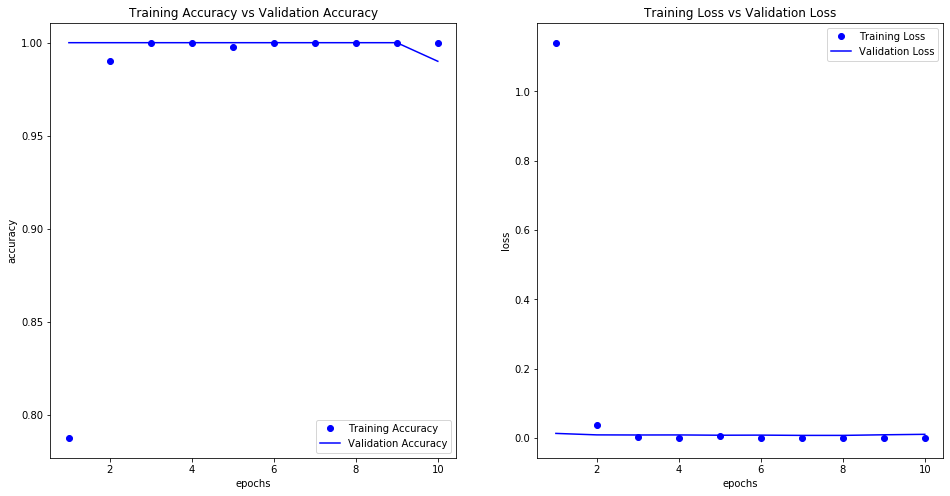

In [12]:
model.save('closing_credits_Resnet50.h5')

plot_train_vs_valid(history)